In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import subprocess
import re
import matplotlib.ticker as ticker
import seaborn

In [2]:


# Takes a list of parameter strings and runs the simulator with each of them
# E.g. run_command(['-ruu:size 2', '-ruu:size 4']) == [
#   {'total_power_cycle_cc1': 1031971444.5013, ... }
#   {'total_power_cycle_cc1': 768561902.5089, ... }
# ]
def run_wattch(paramss):
    # Helper function
    def try_numeral(n):
      try:
        return int(n)
      except ValueError:
        try:
          return float(n)
        except ValueError:
          return n

    # Start all the processes
    procs = [
        subprocess.Popen(
            ['./run-wattch'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            shell=True,
            env={**os.environ.copy(), 'SSFLAGS': params}
        )
        for params in paramss
    ]

    # Wait for them all to finish and parse output
    return pd.DataFrame(
        {
            match.group(1): try_numeral(match.group(2))
            for match in re.finditer(r'\n([^ ]+)[ ]+([^ ]+) \# ', '\n'.join(proc.communicate()))
        }
        for proc in procs
    )

def plot_2d(df, x_var, y_var='total_power_cycle_cc1', title=None, file_name=None):
    plot = seaborn.pointplot(df, x=x_var, y=y_var)
        
    if title:
        plot.set_title(title)

    if file_name:
        plot.get_figure().savefig(f'report/assets/{file_name}.png')

# def plot3d(df, x_var, y_var, z_var='total_power_cycle_cc1'):
#     plt.figure(figsize=(10, 10))
#     ax = plt.axes(projection='3d')
#     ax.bar3d(df[x_var], df[y_var], 0, 3, 3, df[z_var], shade=True)

#     ax.set_xlabel(x_var)
#     ax.xaxis.set_major_locator(ticker.FixedLocator(df[x_var]))
#     ax.set_xticklabels(df[x_var])
#     ax.set_xticks(df[x_var])

#     ax.set_ylabel(y_var)
#     ax.xaxis.set_major_locator(ticker.FixedLocator(df[x_var]))
#     ax.set_yticklabels(df[y_var])
#     ax.set_yticks(df[y_var])
#     ax.invert_yaxis()

#     ax.set_zlabel('total_power_cycle_cc1')
#     plt.show()

def run_and_plot(x_var, x_var_vals, y_var='total_power_cycle_cc1'):
    df = run_wattch([f'{x_var} {x_var_val}' for x_var_val in x_var_vals])
    plot_2d(df, x_var, y_var)

def plot_3d(data, x, y, z='total_power_cycle_cc1', title=None, file_name=None):
    qualitative_colors = seaborn.color_palette("husl", 9)[:len(data[z].unique())]
    
    plot = seaborn.pointplot(data=data, x=x, y=y, hue=z, palette=qualitative_colors)
    
    if title:
        plot.set_title(title)
    
    if file_name:
        plot.get_figure().savefig(f'report/assets/{file_name}.png')


In [3]:
# 1. Vary RUU size
results = run_wattch([
  f'-ruu:size {2 ** i}'
  for i in range(0, 9)
])

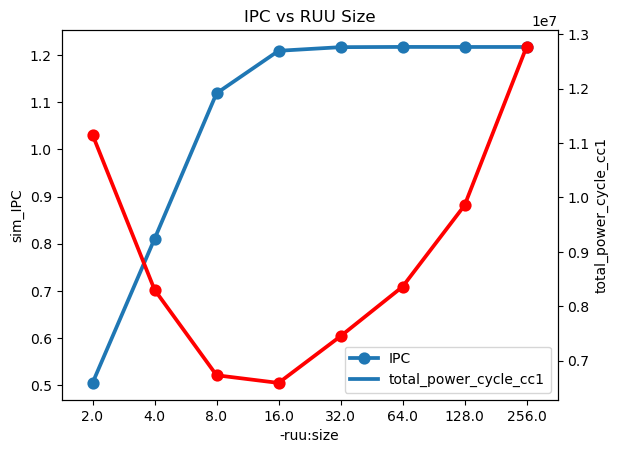

In [4]:

ipc_plot = seaborn.pointplot(results, x='-ruu:size', y='sim_IPC')
ipc_plot.set_title('IPC vs RUU Size')

# Using twinx, we add a second y-axis on the right-hand side which contains total_power_cycle_cc1
ax2 = ipc_plot.twinx()
ax2.set_ylabel('total_power_cycle_cc1')
seaborn.pointplot(results, x='-ruu:size', y='total_power_cycle_cc1', ax=ax2, color='r')

# Show the ledgend so you can tell the two lines apart
ipc_plot.legend(['IPC', 'total_power_cycle_cc1'])

plt.savefig('./report/assets/ipc_vs_ruu_size.png')

In [15]:
# 2. Vary LSQ and RUU at the same time
results = run_wattch([
  f'-ruu:size {2 ** i} -lsq:size {2 ** j}'
  # for i in range(2, 8)
  # for j in range(1, 7)
  for i in range(2, 7)
  for j in range(1, 6)
])

/tmp/ipykernel_2078865/1569257127.py:80: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2078865/1569257127.py:80: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2078865/1569257127.py:80: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2078865/1569257127.py:80: MatplotlibDeprecationWarning: Support for passing numbers through unit con

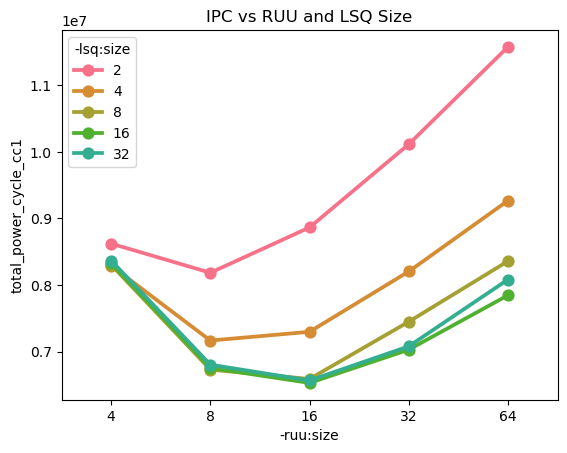

In [16]:
plot_3d(
  results,
  '-ruu:size',
  'total_power_cycle_cc1',
  '-lsq:size',
  'IPC vs RUU and LSQ Size',
  'energy_vs_ruu_and_lsq_size'
)

In [17]:
# 3. Is RUU or LSQ the bottleneck?
increasing_ruu = run_wattch([
  f'-ruu:size {2 ** i}'
  for i in range(4, 9)
])
increasing_lsq = run_wattch([
  f'-lsq:size {2 ** i}'
  for i in range(3, 8)
])

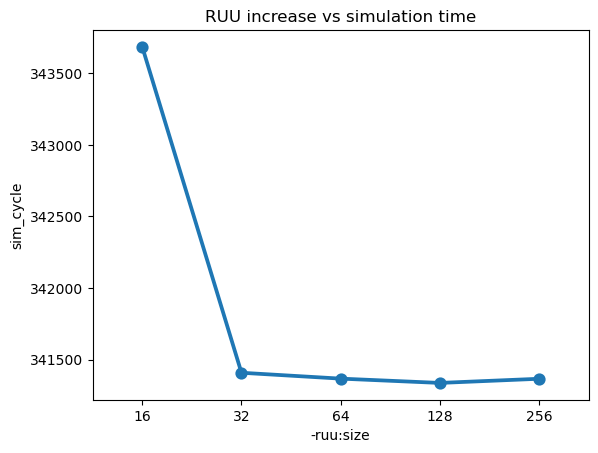

In [18]:

time_plot = seaborn.pointplot(increasing_ruu, x='-ruu:size', y='sim_cycle')
time_plot.set_title('RUU increase vs simulation time')

plt.savefig('./report/assets/ruu_bottleneck.png')

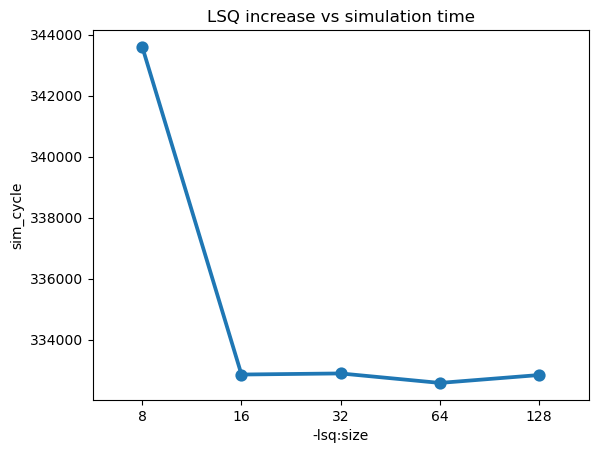

In [19]:
time_plot = seaborn.pointplot(increasing_lsq, x='-lsq:size', y='sim_cycle')
time_plot.set_title('LSQ increase vs simulation time')

plt.savefig('./report/assets/lsq_bottleneck.png')

In [20]:
# 2. Vary LSQ and RUU at the same time
results = run_wattch([
  f'-ruu:size {2 ** i} -lsq:size {2 ** j}'
  for i in range(2, 8)
  for j in range(1, 7)
])

/tmp/ipykernel_2078865/1569257127.py:80: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2078865/1569257127.py:80: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2078865/1569257127.py:80: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plot.get_figure().savefig(f'report/assets/{file_name}.png')
/tmp/ipykernel_2078865/1569257127.py:80: MatplotlibDeprecationWarning: Support for passing numbers through unit con

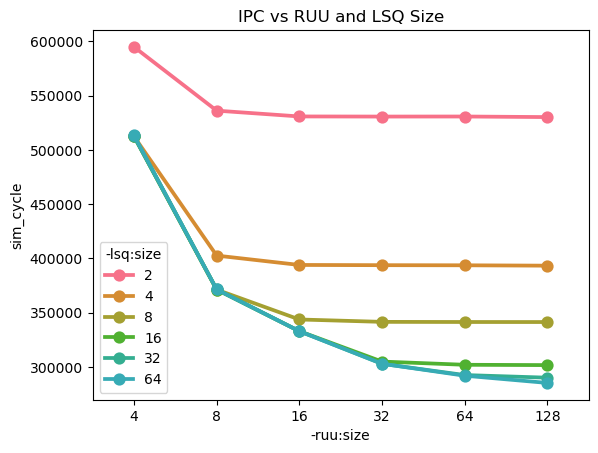

In [21]:
plot_3d(
  results,
  '-ruu:size',
  'sim_cycle',
  '-lsq:size',
  'IPC vs RUU and LSQ Size',
  'ruu_and_lsq_vs_sim_time'
)

In [22]:
bsizes = [8, 16, 32, 64, 128, 256, 512, 1024]
# L1 data cache experiments
cache_results = run_wattch([
  f'-cache:dl1 dl1:{128 * 32//bsize}:{bsize}:4:l'
  for bsize in bsizes
])
cache_results['bsize'] = bsizes

In [ ]:
cache_results[['bsize', '-cache:dl1', 'total_power_cycle_cc1']]

,bsize,-cache:dl1,total_power_cycle_cc1
0,8,dl1:512:8:4:l,7.265133e+06
1,16,dl1:256:16:4:l,6.638169e+06
2,32,dl1:128:32:4:l,6.589291e+06
3,64,dl1:64:64:4:l,6.536725e+06
4,128,dl1:32:128:4:l,3.679770e+01
5,256,dl1:16:256:4:l,3.642690e+01
6,512,dl1:8:512:4:l,3.580540e+01
7,1024,dl1:4:1024:4:l,3.484290e+01


Text(0.5, 1.0, 'Block size vs energy')

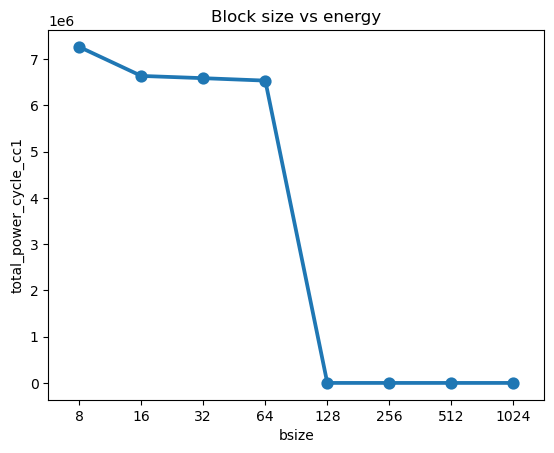

In [ ]:
ipc_plot = seaborn.pointplot(cache_results, x='bsize', y='total_power_cycle_cc1')
ipc_plot.set_title('Block size vs energy')